In [1]:
from typing import Tuple
import pandas as pd
from tqdm.notebook import tqdm
from evaluation.generated_dataset import GeneratedDataset, load_all_from_config
from evaluation.novelty import NoveltyFilter, filter_by_unique_structure

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [2]:
datasets = {
    #"WyckoffTransformer-raw": ("WyckoffTransformer",),
    "WyFormer": ("WyckoffTransformer", "CrySPR", "CHGNet_fix_release"),
    "WyForDiffCSP++": ("WyckoffTransformer", "DiffCSP++", "CHGNet_fix"),
    #"WyckoffTransformer-free": ("WyckoffTransformer", "CrySPR", "CHGNet_free"),
    "CrystalFormer": ("CrystalFormer", "CHGNet_fix_release"),
    #"DiffCSP++ raw": ("DiffCSP++",),
    "DiffCSP++": ("DiffCSP++", "CHGNet_fix_release"),
    "DiffCSP": ("DiffCSP", "CHGNet_fix"),
    "FlowMM": ("FlowMM", "CHGNet_fix"),
    #"MP-20 train": ("split", "train"),
    #"MP-20 test": ("split", "test"),
}
raw_datasets = {
    "WyFormer": ("WyckoffTransformer", "CrySPR", "CHGNet_fix_release"),
    "WyFormerDiffCSP++": ("WyckoffTransformer", "DiffCSP++"),
    "CrystalFormer": ("CrystalFormer",),
    "DiffCSP++": ("DiffCSP++",),
    "DiffCSP": ("DiffCSP",),
    "FlowMM": ("FlowMM",),
}

In [3]:
all_datasets = load_all_from_config(
    datasets=list(datasets.values()) + list(raw_datasets.values()) + \
        [("split", "train"), ("split", "val"), ("split", "test"), ("WyckoffTransformer", "CrySPR", "CHGNet_fix")],
    dataset_name="mp_20")

In [4]:
len(all_datasets[('split', 'train')].data) 

27136

In [5]:
datasets["WyCryst"] = ('WyCryst', 'CHGNet_fix')
raw_datasets["WyCryst"] = ('WyCryst', 'CHGNet_fix')
all_datasets[('WyCryst', 'CHGNet_fix')] = GeneratedDataset.from_cache(('WyCryst', 'CHGNet_fix'), "mp_20_biternary")

In [6]:
novelty_reference = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'val')].data], axis=0, verify_integrity=True)
novelty_filter = NoveltyFilter(novelty_reference)

In [7]:
import evaluation.statistical_evaluator
test_unique = filter_by_unique_structure(all_datasets[('split', 'test')].data)
test_novel = novelty_filter.get_novel(test_unique)
test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(test_novel)

In [8]:
import evaluation.novelty
train_w_template_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1))
train_strict_AFLOW_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1))
train_relaxed_AFLOW_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_relaxed_AFLOW_fingerprint, axis=1))

In [9]:
def is_sg_preserved(relaxed_sg, transformations: Tuple[str]) -> pd.Series:
    source_sg = all_datasets[(transformations[0],)].data.spacegroup_number
    return relaxed_sg == source_sg.reindex_like(relaxed_sg)

In [10]:
mp_20 = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'test')].data,
    all_datasets[('split', 'val')].data], axis=0, verify_integrity=True)
(mp_20.spacegroup_number == 1).mean()
mp_20.smact_validity.mean()

0.9057020937893829

In [11]:
1-mp_20.smact_validity.mean()

0.09429790621061707

In [20]:
mp_20.sites.apply(len).mean()

3.012403546397223

In [ ]:
top_10_groups = frozenset(mp_20.spacegroup_number.value_counts().iloc[:10].index)
n_elements_dist = {}

In [113]:
table = pd.DataFrame(
    index=datasets.keys(), columns=[
        "Novelty (%)", "Structural", "Compositional", 
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements",
        "S.U.N. (%)",
        "Top-10 S.U.N. (%)",
        "Novel Template (%)", 
        "Novel AFLOW on P1",
        "Novel AFLOW on !P1",
        "Novel AFLOW (%)",
        "Novel AFLOW relaxed (%)",
        "P1 (%)",
        "Space Group", "S.S.U.N. (%)"])
table.index.name = "Method"
E_hull_threshold = 0.08
for name, transformations in tqdm(datasets.items()):
    dataset = all_datasets[transformations]
    unique = filter_by_unique_structure(dataset.data)
    print(f"Unique: {len(unique)} / {len(dataset.data)} = {len(unique) / len(dataset.data)}")
    novel_template = ~unique.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1).isin(train_w_template_set)
    table.loc[name, "Novel Template (%)"] = 100 * novel_template.mean()
    novel_aflow_strict = ~unique.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1).isin(train_strict_AFLOW_set)
    table.loc[name, "Novel AFLOW (%)"] = 100 * novel_aflow_strict.mean()
    novel_aflow_relaxed = ~unique.apply(evaluation.novelty.record_to_relaxed_AFLOW_fingerprint, axis=1).isin(train_relaxed_AFLOW_set)
    table.loc[name, "Novel AFLOW relaxed (%)"] = 100 * novel_aflow_relaxed.mean()
    unique_is_P1 = unique.group == 1
    table.loc[name, "Novel AFLOW on P1"] = 100 * novel_aflow_strict[unique_is_P1].mean()
    table.loc[name, "Novel AFLOW on !P1"] = 100 * novel_aflow_strict[~unique_is_P1].mean()
    if transformations == ("split", "train"):
        novel = unique
    else:
        novel = novelty_filter.get_novel(unique)
    table.loc[name, "Novelty (%)"] = 100 * len(novel) / len(unique)
    if "structural_validity" in novel.columns:
        table.loc[name, "Structural"] = 100 * novel.structural_validity.mean()
        table.loc[name, "Compositional"] = 100 * novel.smact_validity.mean()
    if "cdvae_crystal" in novel.columns:
        cov_metrics = test_evaluator.get_coverage(novel.cdvae_crystal)    
        table.loc[name, "Recall"] = 100 * cov_metrics["cov_recall"]
        table.loc[name, "Precision"] = 100 * cov_metrics["cov_precision"]
        novel = novel[novel.structural_validity]
        table.loc[name, r"$\rho$"] = test_evaluator.get_density_emd(novel)
        table.loc[name, "$E$"] = test_evaluator.get_cdvae_e_emd(novel)
        table.loc[name, "# Elements"] = test_evaluator.get_num_elements_emd(novel)
        n_elements_dist[name] = novel.elements.apply(lambda e: len(frozenset(e))).value_counts() / len(novel)
    table.loc[name, "P1 (%)"] = 100 * (novel.group == 1).mean()
    # table.loc[name, "# DoF"] = test_evaluator.get_dof_emd(novel)
    table.loc[name, "Space Group"] = test_evaluator.get_sg_chi2(novel)
    #try:
    #    table.loc[name, "SG preserved (%)"] = 100 * is_sg_preserved(novel.spacegroup_number, transformations).mean()
    #except KeyError:
    #    pass
    #table.loc[name, "Elements"] = test_evaluator.get_elements_chi2(novel)
    if "corrected_chgnet_ehull" in novel.columns:
        # S.U.N. is measured with respect to the initial structures
        has_ehull = dataset.data.corrected_chgnet_ehull.notna().sum()
        is_sun = (novel.corrected_chgnet_ehull <= E_hull_threshold) # & (novel.elements.apply(lambda x: len(frozenset(x))) >= 2)
        table.loc[name, "S.U.N. (%)"] = 100 * is_sun.sum() / has_ehull
        table.loc[name, "S.S.U.N. (%)"] = 100 * (is_sun & (novel.group != 1)).sum() / has_ehull
        has_ehull_top_10 = dataset.data[dataset.data.spacegroup_number.isin(top_10_groups)].corrected_chgnet_ehull.notna().sum()
        table.loc[name, "Top-10 S.U.N. (%)"] = 100 * is_sun[novel.spacegroup_number.isin(top_10_groups)].sum() / has_ehull_top_10
    if transformations == ("split", "train"):
        # Train forms the baseline of the hull
        test_dataset = all_datasets[("split", "test", "CHGNet_fix")].data
        test_with_ehull = test_dataset[test_dataset.corrected_chgnet_ehull.notna()]
        test_unique = filter_by_unique_structure(test_with_ehull)
        test_novel = novelty_filter.get_novel(test_unique)
        table.loc[name, "S.U.N. (%)"] = 100 * (test_novel.corrected_chgnet_ehull <= E_hull_threshold).sum() / len(test_with_ehull)
n_elements_dist["MP-20"] = mp_20.elements.apply(lambda e: len(frozenset(e))).value_counts() / len(mp_20)
table

  0%|          | 0/7 [00:00<?, ?it/s]

Unique: 1000 / 1000 = 1.0
Unique: 1000 / 1000 = 1.0
Unique: 988 / 992 = 0.9959677419354839
Unique: 999 / 1000 = 0.999
Unique: 996 / 1000 = 0.996
Unique: 994 / 997 = 0.9969909729187563
Unique: 994 / 994 = 1.0


,Novelty (%),Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements,S.U.N. (%),Top-10 S.U.N. (%),Novel Template (%),Novel AFLOW on P1,Novel AFLOW on !P1,Novel AFLOW (%),Novel AFLOW relaxed (%),P1 (%),Space Group,S.S.U.N. (%)
Method,,,,,,,,,,,,,,,,,,
WyFormer,90.0,99.555556,80.444444,98.666667,96.715328,0.73714,0.053159,0.096566,38.938939,44.190871,19.8,73.333333,35.463918,36.6,35.2,3.236607,0.222677,38.038038
WyForDiffCSP++,89.5,99.664804,80.335196,99.217877,96.792745,0.665291,0.050328,0.098188,36.6,39.314516,20.0,76.923077,36.068896,36.6,35.4,1.457399,0.211951,35.9
CrystalFormer,76.923077,86.842105,82.368421,99.868421,95.13382,0.524171,0.099555,0.163017,33.870968,36.6,9.716599,71.428571,26.694045,27.327935,26.417004,0.909091,0.276161,33.770161
DiffCSP++,89.68969,100.0,85.044643,99.330357,95.79739,0.147837,0.036122,0.503632,41.4,46.563193,1.001001,78.26087,29.303279,30.43043,28.828829,2.566964,0.25525,40.8
DiffCSP,90.060241,100.0,80.936455,99.554069,96.206591,0.822378,0.052409,0.293636,57.4,56.818182,9.538153,63.414634,33.832335,43.574297,42.871486,36.566332,7.988511,40.6
FlowMM,90.140845,96.205357,82.477679,99.665179,96.361424,0.315307,0.044476,0.114668,49.548646,54.464286,6.136821,49.888641,30.275229,39.134809,37.122736,49.303944,14.007995,29.889669
WyCryst,52.615694,99.808795,75.525813,98.852772,87.104623,0.962397,0.112944,0.285756,36.619718,31.311155,17.203219,68.0,26.625387,27.665996,26.760563,4.789272,0.710472,35.211268


In [133]:
all_datasets[('split', 'test')].data.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1).isin(train_w_template_set).mean()

0.9713685606898077

In [135]:
all_datasets[('split', 'test')].data.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1).isin(train_strict_AFLOW_set).mean()

0.9328985186822906

In [119]:
n_elements_dist["MP-20"][2] + n_elements_dist["MP-20"][3]

0.7866192044926927

In [125]:
adjusted_dist

elements
3    0.745211
2    0.254789
Name: count, dtype: float64

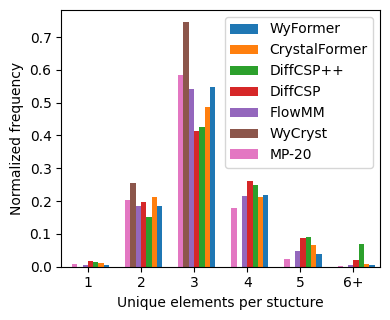

In [142]:
import matplotlib.pyplot as plt
fig_n_elements, ax_n_elements = plt.subplots(figsize=(4, 3.3))
width = 0.1
max_elements = 6
n_elemnts_to_plot = n_elements_dist.copy()
del n_elemnts_to_plot["WyForDiffCSP++"]
for plot_index, (name, dist) in enumerate(n_elemnts_to_plot.items()):
    adjusted_dist = dist.loc[dist.index <= max_elements].copy()
    if max_elements in adjusted_dist.index:
        adjusted_dist[max_elements] += dist.loc[dist.index > max_elements].sum()
    ax_n_elements.bar(adjusted_dist.index + (len(n_elemnts_to_plot) / 2 - plot_index) * width,
                      adjusted_dist, width, label=name)# EMD = {table.loc[name, "# Elements"]:.2f}")
ax_n_elements.set_xlabel("Unique elements per stucture")
ax_n_elements.set_ylabel("Normalized frequency")
ax_n_elements.legend()
ax_n_elements.set_xticks(range(1, max_elements + 1))
ax_n_elements.set_xlim(0.5, max_elements + 0.5)
x_ticks = list(range(1, max_elements)) + [f"{max_elements}+"]
ax_n_elements.set_xticklabels(x_ticks)
fig_n_elements.tight_layout()
fig_n_elements.savefig("plots/ICLR_rebuttal/unique_elements_distribution.pdf");

In [25]:
table[["Novel Template (%)", "Novel AFLOW on P1", "Novel AFLOW on !P1", "Novel AFLOW (%)", "Novelty (%)"]].style.format("{:.1f}")

,Novel Template (%),Novel AFLOW on P1,Novel AFLOW on !P1,Novel AFLOW (%),Novelty (%)
Method,,,,,
WyFormer,19.8,73.3,35.5,36.6,90.0
WyForDiffCSP++,20.0,76.9,36.1,36.6,89.5
CrystalFormer,9.7,71.4,26.7,27.3,76.9
DiffCSP++,1.0,78.3,29.3,30.4,89.7
DiffCSP,9.5,63.4,33.8,43.6,90.1
FlowMM,6.1,49.9,30.3,39.1,90.1
WyCryst,17.2,68.0,26.6,27.7,52.6


In [14]:
table.to_csv("tables/paper_summary_table.csv")
table.to_pickle("tables/paper_summary_table.pkl")

In [15]:
max_subset=["Novelty (%)", "Structural", "Compositional", "Recall", "Precision", "S.S.U.N. (%)", "S.U.N. (%)", "Novel Template (%)"]
# -1 to exclude the MP-20 training set
def highlight_max_value(s):
    if s.name not in max_subset:
        return ['' for _ in s]
    is_max = s == s.max()
    #is_max.iloc[-1] = False
    return ['font-weight: bold' if v else '' for v in is_max]

min_subset=[r"$\rho$", "$E$", "# Elements", "# DoF", "Space Group", "Elements", "P1 (%)"]
def highlight_min_value(s):
    if s.name not in min_subset:
        return ['' for _ in s]
    is_min = s == s.min()
    #is_min.iloc[-1] = False
    return ['font-weight: bold' if v else '' for v in is_min]

In [16]:
def prettify(table):
    return table.style.format({
    "Novelty (%)": "{:.2f}",
    "Structural": "{:.2f}",
    "Compositional": "{:.2f}",
    "Recall": "{:.2f}",
    "Precision": "{:.2f}",
    r"$\rho$": "{:.2f}",
    "$E$": "{:.3f}",
    "# Elements": "{:.3f}",
    "# DoF": "{:.3f}",
    "Space Group": "{:.3f}",
    "Elements": "{:.3f}",
    "Novel Template (%)": "{:.2f}",
    "P1 (%)": "{:.2f}",
    "S.U.N. (%)": "{:.1f}",
    "S.S.U.N. (%)": "{:.1f}",
}).apply(highlight_max_value).apply(highlight_min_value)
prettify(table)

,Novelty (%),Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements,S.U.N. (%),Novel Template (%),Novel AFLOW strict (%),Novel AFLOW relaxed (%),P1 (%),Space Group,S.S.U.N. (%)
Method,,,,,,,,,,,,,,,
WyFormer,90.00,99.56,80.44,98.67,96.72,0.74,0.053,0.097,38.9,19.80,36.600000,35.200000,3.24,0.223,38.0
WyForDiffCSP++,89.50,99.66,80.34,99.22,96.79,0.67,0.050,0.098,36.6,20.00,36.600000,35.400000,1.46,0.212,35.9
CrystalFormer,76.92,86.84,82.37,99.87,95.13,0.52,0.100,0.163,33.9,9.72,27.327935,26.417004,0.91,0.276,33.8
DiffCSP++,89.69,100.00,85.04,99.33,95.80,0.15,0.036,0.504,41.4,1.00,30.430430,28.828829,2.57,0.255,40.8
DiffCSP,90.06,100.00,80.94,99.55,96.21,0.82,0.052,0.294,57.4,9.54,43.574297,42.871486,36.57,7.989,40.6
FlowMM,90.14,96.21,82.48,99.67,96.36,0.32,0.044,0.115,49.5,6.14,39.134809,37.122736,49.30,14.008,29.9
WyCryst,52.62,99.81,75.53,98.85,87.10,0.96,0.113,0.286,36.6,17.20,27.665996,26.760563,4.79,0.710,35.2


In [17]:
prettify(table.iloc[:, :9]).to_latex("tables/summary_similarity_raw.tex", siunitx=True, convert_css=True)
prettify(table.iloc[:, 9:]).to_latex("tables/summary_symmetry_raw.tex", siunitx=True, convert_css=True)

In [18]:
raw_test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(all_datasets[('split', 'test')].data)
cdvae_table = pd.DataFrame(index=pd.Index(datasets.keys(), tupleize_cols=False),
    columns=[
        "Structural", "Compositional",
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements"])
sample_size = 992
for name, transformations in tqdm(datasets.items()):
    dataset = all_datasets[transformations]
    if "structure" in dataset.data.columns:
        cdvae_table.loc[name, "Compositional"] = 100*dataset.data.smact_validity.mean()
        cdvae_table.loc[name, "Structural"] = 100*dataset.data.structural_validity.mean()
        valid = dataset.data[dataset.data.naive_validity]
        cov_metrics = raw_test_evaluator.get_coverage(valid.cdvae_crystal)
        cdvae_table.loc[name, "Recall"] = 100*cov_metrics["cov_recall"]
        cdvae_table.loc[name, "Precision"] = 100*cov_metrics["cov_precision"]
        cdvae_table.loc[name, r"$\rho$"] = raw_test_evaluator.get_density_emd(valid)
        cdvae_table.loc[name, "$E$"] = raw_test_evaluator.get_cdvae_e_emd(valid)
        cdvae_table.loc[name, "# Elements"] = raw_test_evaluator.get_num_elements_emd(valid)
cdvae_table.to_csv("tables/cdvae_metrics_table.csv")
prettify(cdvae_table).to_latex("tables/cdvae_metrics_table.tex", siunitx=True, convert_css=True)
prettify(cdvae_table)

  0%|          | 0/7 [00:00<?, ?it/s]

,Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements
WyFormer,99.60,81.40,98.77,95.94,0.39,0.078,0.081
WyForDiffCSP++,99.70,81.40,99.26,95.85,0.33,0.070,0.078
CrystalFormer,89.92,84.88,99.87,95.45,0.19,0.139,0.119
DiffCSP++,100.00,85.80,99.42,95.48,0.13,0.036,0.453
DiffCSP,100.00,82.50,99.64,95.18,0.46,0.075,0.321
FlowMM,96.59,83.25,99.75,95.83,0.17,0.055,0.107
WyCryst,99.90,82.09,99.63,96.16,0.44,0.330,0.322


In [19]:
raw_test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(all_datasets[('split', 'test')].data)
cdvae_table = pd.DataFrame(index=pd.Index(raw_datasets.keys(), tupleize_cols=False),
    columns=[
        "Structural", "Compositional",
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements"])
sample_size = 992
for name, transformations in tqdm(raw_datasets.items()):
    dataset = all_datasets[transformations]
    if "structure" in dataset.data.columns:
        cdvae_table.loc[name, "Compositional"] = 100*dataset.data.smact_validity.mean()
        cdvae_table.loc[name, "Structural"] = 100*dataset.data.structural_validity.mean()
        valid = dataset.data[dataset.data.naive_validity]
        cov_metrics = raw_test_evaluator.get_coverage(valid.cdvae_crystal)
        cdvae_table.loc[name, "Recall"] = 100*cov_metrics["cov_recall"]
        cdvae_table.loc[name, "Precision"] = 100*cov_metrics["cov_precision"]
        cdvae_table.loc[name, r"$\rho$"] = raw_test_evaluator.get_density_emd(valid)
        cdvae_table.loc[name, "$E$"] = raw_test_evaluator.get_cdvae_e_emd(valid)
        cdvae_table.loc[name, "# Elements"] = raw_test_evaluator.get_num_elements_emd(valid)
cdvae_table.to_csv("tables/cdvae_metrics_no_relax_table.csv")
prettify(cdvae_table).to_latex("tables/cdvae_metrics_no_relax_table.tex", siunitx=True, convert_css=True)
prettify(cdvae_table)

  0%|          | 0/7 [00:00<?, ?it/s]

,Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements
WyFormer,99.60,81.40,98.77,95.94,0.39,0.078,0.081
WyFormerDiffCSP++,99.80,81.40,99.51,95.81,0.36,0.083,0.079
CrystalFormer,93.39,84.98,99.62,94.56,0.19,0.208,0.128
DiffCSP++,99.94,85.13,99.67,99.54,0.31,0.069,0.399
DiffCSP,100.00,83.20,99.82,99.51,0.35,0.095,0.347
FlowMM,96.87,83.11,99.73,99.39,0.12,0.073,0.094
WyCryst,99.90,82.09,99.63,96.16,0.44,0.330,0.322
